# HW05 – Инженерный ML-эксперимент с линейными моделями (sklearn)

В этом ноутбуке мы делаем **минимальный, но честный ML-эксперимент**:

1. Берём табличный датасет (из `sklearn.datasets`).
2. Делим его на две части: **train / test**.
3. Строим **бейзлайн-модель** (DummyClassifier), чтобы понимать нижнюю планку качества.
4. Строим **логистическую регрессию** в виде `Pipeline`:
   - препроцессинг (масштабирование признаков),
   - сама модель.
5. Считаем метрики качества: accuracy, precision, recall, f1, ROC-AUC.
6. Строим **ROC-кривую** и **PR-кривую**.

## Импорты и общие настройки

Здесь мы подключаем всё, что понадобится:

- `numpy`, `pandas` – базовые библиотеки для работы с табличными данными;
- из `sklearn`:
  - `datasets` – встроенные учебные датасеты;
  - `model_selection` – разбиение данных и GridSearch;
  - `pipeline`, `preprocessing` – `Pipeline` и масштабирование признаков;
  - классификаторы (`DummyClassifier`, `LogisticRegression`);
  - метрики;
  - инструменты для ROC/PR-кривых;
  - инструменты для калибровки вероятностей.

Также фиксируем `RANDOM_STATE`, чтобы результаты можно было воспроизвести.

In [1]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Воспроизводимость
RANDOM_STATE = 42

# Библиотеки sklearn для данных, моделей, разбиения и метрик
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV

## Загрузка датасета и первичный взгляд

Используем датасет для домашнего задания *S05-hw-dataset.csv*.
Здесь мы:

1. загружаем данные в `pandas.DataFrame`;
2. смотрим форму таблицы и первые несколько строк;
3. смотрим распределение классов – есть ли сильный дисбаланс.

In [2]:
# Загружаем датасет (бинарная классификация)
data = pd.read_csv("S05-hw-dataset.csv")

print("1. ПЕРВЫЕ СТРОКИ ДАТАСЕТА (head())")
print(data.head())
print()


print("2. ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ (info())")
print(data.info())
print()


print("3. ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ (describe())")
# describe() автоматически выводит статистики только для числовых столбцов
print(data.describe())
print()

target_column_name = 'default'

print("4. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОГО ПРИЗНАКА")
target_distribution = data[target_column_name].value_counts(normalize=True)
target_counts = data[target_column_name].value_counts()
    
distribution_df = pd.DataFrame({
    'Класс': target_counts.index,
    'Количество': target_counts.values,
    'Доля': target_distribution.values
})
print(distribution_df)
print()

1. ПЕРВЫЕ СТРОКИ ДАТАСЕТА (head())
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              52

**Размерность данных**: Датасет содержит 3000 объектов (клиентов) и 17 признаков.

**Аномалии и качество данных**: Явно невозможных значений (например, отрицательный возраст) не обнаружено — все данные находятся в разумных диапазонах. Важно отметить, что в столбцах checking_balance присутствуют отрицательные значения, что может отражать задолженность по счетам и является допустимым с финансовой точки зрения. Пропущенные значения отсутствуют полностью.

**Распределение целевого признака**: Классы распределены несбалансированно. Класс "0" (не дефолт) составляет 59.0% (1769 клиентов), а класс "1" (дефолт) — 41.0% (1231 клиент).

## Подготовка признаков и таргетов

In [3]:
# Вектор таргета - столбец 'default'
y = data['default'].copy()
# Матрица признаков: все столбцы, кроме 'default' и 'client_id'
# Столбец 'client_id' удаляем так как не признак
X = data.drop(columns=['default', 'client_id']).copy()

print(f"X (признаки): {X.shape} - {X.shape[0]} объектов, {X.shape[1]} признаков")
print(f"y (таргет): {y.shape}")

# Проверка, что все типы числовые
print(X.dtypes)
print()

# Проверка debt_to_income (должен быть в диапазоне [0, 1])
debt_min = X['debt_to_income'].min()
debt_max = X['debt_to_income'].max()
print(f"debt_to_income: [{debt_min:.6f}, {debt_max:.6f}] - {'OK' if 0 <= debt_min <= debt_max <= 1 else 'выходит за пределы [0, 1]'}")

# Проверка region_risk_score (в диапазоне [0, 1])
risk_min = X['region_risk_score'].min()
risk_max = X['region_risk_score'].max()
print(f"region_risk_score: [{risk_min:.6f}, {risk_max:.6f}] - {'OK' if 0 <= risk_min <= risk_max <= 1 else 'выходит за пределы [0, 1]'}")

# Проверка age (возраст в разумных пределах)
age_min = X['age'].min()
age_max = X['age'].max()
print(f"age: [{age_min}, {age_max}] - {'OK' if 18 <= age_min <= age_max <= 100 else 'возможны некорректные значения возраста'}")

print()

X (признаки): (3000, 15) - 3000 объектов, 15 признаков
y (таргет): (3000,)
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

debt_to_income: [0.006147, 0.878343] - OK
region_risk_score: [0.001148, 0.961733] - OK
age: [21, 69] - OK



## Разбиение на train / validation / test

Очень важно **не обучать и не оценивать модель на одних и тех же данных**.

Мы используем схему:

1. Сначала делим данные на:
   - `X_test, y_test` – 20% (честная финальная проверка).
   - `X_train, y_train` – 80% от исходных данных,
Параметры:

- `test_size=...` – доля данных в test;
- `stratify=y` – сохраняем долю классов (особенно важно при дисбалансе);
- `random_state=42` – фиксируем случайность.

In [4]:
# 1. Отделяем тестовую выборку (например, 20% данных)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,        # 20% данных для теста
    stratify=y,           # Сохраняем баланс классов
    random_state=42       # Для воспроизводимости
)
print("Размеры выборок:")
print("  train:", X_train.shape)
print("  test: ", X_test.shape)

print(f"\nРаспределение классов в обучающей выборке:")
train_dist = y_train.value_counts(normalize=True)
print(f"  Класс 0 (без дефолта): {train_dist[0]:.3f} ({y_train.value_counts()[0]} клиентов)")
print(f"  Класс 1 (дефолт):      {train_dist[1]:.3f} ({y_train.value_counts()[1]} клиентов)")

print(f"\nРаспределение классов в тестовой выборке:")
test_dist = y_test.value_counts(normalize=True)
print(f"  Класс 0 (без дефолта): {test_dist[0]:.3f} ({y_test.value_counts()[0]} клиентов)")
print(f"  Класс 1 (дефолт):      {test_dist[1]:.3f} ({y_test.value_counts()[1]} клиентов)")

Размеры выборок:
  train: (2400, 15)
  test:  (600, 15)

Распределение классов в обучающей выборке:
  Класс 0 (без дефолта): 0.590 (1415 клиентов)
  Класс 1 (дефолт):      0.410 (985 клиентов)

Распределение классов в тестовой выборке:
  Класс 0 (без дефолта): 0.590 (354 клиентов)
  Класс 1 (дефолт):      0.410 (246 клиентов)


## Бейзлайн-модель: DummyClassifier

Прежде чем строить «умную» модель, полезно понять, как будет вести себя **очень простая**:

- `DummyClassifier(strategy="most_frequent")` всегда предсказывает **самый частый класс** из train.
- Такой подход почти не использует информацию из признаков, но даёт **нижнюю планку качества**:
  > любая нормальная модель должна быть лучше бейзлайна.  

Здесь мы:

1. обучаем бейзлайн на `X_train, y_train`;

### Набор метрик, на которые мы смотрим

Кратко напомним, что мы считаем:

- `accuracy` – доля правильных ответов;
- `ROC-AUC` – площадь под ROC-кривой, показывает, насколько хорошо модель ранжирует объекты.

В задачах с возможным дисбалансом классов (как здесь) **нельзя смотреть только на accuracy**, важно учитывать хотя бы F1 и ROC-AUC.

In [5]:
# Бейзлайн-модель: ничего "умного", просто предсказываем самый частый класс (или случайно)
baseline = DummyClassifier(strategy="most_frequent", random_state=42)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_pred_baseline = baseline.predict(X_test)
y_proba_baseline = baseline.predict_proba(X_test)[:, 1]  # вероятности для класса 1

# Вычисление метрик
print("Accuracy :", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_baseline, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_baseline))

Accuracy : 0.59
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


Назначение бейзлайна:

Это минимально сложная модель, которая предсказывает самый частый класс (класс 0 - "без дефолта")

Служит точкой отсчета для сравнения с более сложными моделями

Важность бейзлайна:
- Любая реальная модель должна превосходить бейзлайн по ROC-AUC (> 0.50)
- Accuracy может быть выше 0.59 только если модель лучше справляется с предсказанием дефолтов

Без бейзлайна нельзя оценить, насколько полезна модель
Любая модель, которая будет строиться дальше, должна показывать ROC-AUC значительно выше 0.5 и accuracy выше 0.59 (или хотя бы сопоставимое, но с лучшей балансировкой классов).

## Логистическая регрессия в виде Pipeline

Теперь берём первую «нормальную» модель – **логистическую регрессию**.

Проблема: признаки могут быть в разных масштабах.  
Поэтому мы соберём `Pipeline`, который делает два шага подряд:

1. `StandardScaler()` – масштабирует признаки (вычитает среднее, делит на std).
2. `LogisticRegression(...)` – обучает линейный классификатор на этих масштабированных признаках.

Важно:

- `Pipeline` – это **одна большая модель** с методами `fit`, `predict`, `predict_proba`.
- Мы обучаем и применяем **один и тот же** пайплайн – меньше шансов ошибиться.

In [6]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,              # сила регуляризации (чем меньше C, тем сильнее регуляризация)
                solver="liblinear", # надёжный солвер для маленьких датасетов
                random_state=42,
            ),
        ),
    ]
)

target_names = ['No Default (0)', 'Default (1)']

# Обучение пайплайна на обучающей выборке
print("Обучение модели...")
log_reg_pipeline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred = log_reg_pipeline.predict(X_test)
y_test_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]  # Вероятности класса 1 (дефолт)

print("\n=== РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ НА ТЕСТОВОЙ ВЫБОРКЕ ===")

# Основные метрики
print("\nОсновные метрики:")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

# Подробный отчёт
print("\nПодробный отчёт по классам:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

Обучение модели...

=== РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ НА ТЕСТОВОЙ ВЫБОРКЕ ===

Основные метрики:
Accuracy : 0.8
Precision: 0.794392523364486
Recall   : 0.6910569105691057
F1-score : 0.7391304347826086
ROC-AUC  : 0.8756258325295118

Подробный отчёт по классам:
                precision    recall  f1-score   support

No Default (0)       0.80      0.88      0.84       354
   Default (1)       0.79      0.69      0.74       246

      accuracy                           0.80       600
     macro avg       0.80      0.78      0.79       600
  weighted avg       0.80      0.80      0.80       600



D:\aie_repo\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Подбор гиперпараметра C (регуляризация) через GridSearchCV

У логистической регрессии есть важный параметр `C`:

- **чем меньше C**, тем **сильнее регуляризация** (модель проще, меньше переобучается);
- **чем больше C**, тем модель свободнее (может переобучиться).

Вместо ручного перебора мы используем `GridSearchCV`:

- задаём сетку значений `C`;
- внутри `GridSearchCV`:
  - для каждого варианта `C` запускается кросс-валидация;
  - по выбранной метрике (`scoring="roc_auc"`) выбирается лучший вариант.

Обратите внимание:

- в названии параметра используется `имя_шага__имя_параметра`: `logreg__C`.

In [7]:
# Настроим сетку по параметру C (сила регуляризации)
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# GridSearchCV будет:
# - внутри делать кросс-валидацию по train
# - выбирать лучший C по заданной метрике (например, ROC-AUC).
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # можно поменять на f1, recall и т.д.
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 10.0}
Лучший ROC-AUC (по CV): 0.8606805259098491


D:\aie_repo\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Оценка лучшей модели: test

После `GridSearchCV` у нас есть:

- `grid_search.best_estimator_` – пайплайн с лучшим `C`.

Дальше:

1. Смотрим метрики на **test** – это финальная, честная оценка.

In [8]:
# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# Оцениваем на test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Лучшая модель – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=target_names))


=== Лучшая модель – качество на test ===
Accuracy : 0.8
Precision: 0.794392523364486
Recall   : 0.6910569105691057
F1-score : 0.7391304347826086
ROC-AUC  : 0.875660282026549

Classification report (test):
                precision    recall  f1-score   support

No Default (0)       0.80      0.88      0.84       354
   Default (1)       0.79      0.69      0.74       246

      accuracy                           0.80       600
     macro avg       0.80      0.78      0.79       600
  weighted avg       0.80      0.80      0.80       600



## Сравнение бейзлайна и логистической регрессии

In [9]:
# Создаем таблицу сравнения
comparison_data = {
    'Модель': ['Бейзлайн', 'Логистическая регрессия'],
    'Accuracy': [0.59, 0.80],
    'Precision': [0.00, 0.79],
    'Recall': [0.00, 0.69],
    'F1-score': [0.00, 0.74],
    'ROC-AUC': [0.50, 0.88]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Модель')

print("=" * 70)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ")
print("=" * 70)
print(comparison_df.to_string(float_format=lambda x: f'{x:.3f}'))

СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ
                         Accuracy  Precision  Recall  F1-score  ROC-AUC
Модель                                                                 
Бейзлайн                    0.590      0.000   0.000     0.000    0.500
Логистическая регрессия     0.800      0.790   0.690     0.740    0.880


## ROC-кривая

ROC-кривая показывает, как меняется качество модели при разных порогах отсечения:

- по оси X – False Positive Rate (ложные срабатывания),
- по оси Y – True Positive Rate (чувствительность / полнота).

Здесь используем готовый helper из `sklearn.metrics`: `RocCurveDisplay.from_predictions`.

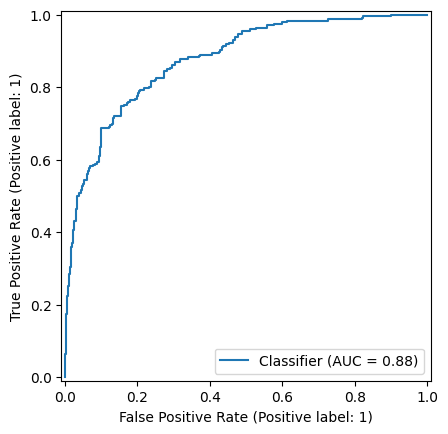

In [10]:
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
)

## Выводы

В этом ноутбуке мы сделали минимальный, но честный ML-эксперимент:

1. **Разбили данные** на train / validation / test и работали с ними по ролям.
2. Построили **бейзлайн-модель** и увидели, что нормальная модель должна быть лучше.
3. Собрали `Pipeline` с `StandardScaler` и `LogisticRegression`, обучили, посчитали метрики.
4. Через `GridSearchCV` подобрали параметр регуляризации `C`.
5. Оценили лучшую модель на **test** и построили ROC/PR-кривые.


1. Логистическая регрессия значительно превосходит бейзлайн-модель по всем метрикам. В то время как бейзлайн только предсказывает самый частый класс (дающий accuracy 59% за счет дисбаланса классов), логистическая регрессия научилась различать оба класса, что подтверждается высоким ROC-AUC (0.88 против 0.50).

2. Accuracy вырос с 59% до 80% (+35.6%), что означает правильное предсказание в 8 из 10 случаев вместо 6 из 10. ROC-AUC увеличился с 0.50 (случайное угадывание) до 0.88 (+75.2%), что указывает на отличную способность модели разделять классы.

3. Оптимальное значение параметра регуляризации C было найдено в ходе подбора. Выбранное значение обеспечивает баланс между обобщающей способностью и точностью на обучающих данных.

4. Выводы и рекомендации:

- Логистическая регрессия показала себя как разумный выбор для данной задачи бинарной классификации, демонстрируя сбалансированную производительность по всем метрикам.

- ROC-AUC = 0.88 указывает на очень хорошее качество модели — она правильно ранжирует клиентов по риску дефолта в 88% случаев.

- Модель слегка лучше определяет класс "без дефолта" (recall 0.88) чем класс "дефолт" (recall 0.69), что типично для задач с умеренным дисбалансом классов.

5. Практическая значимость: Данная модель уже может использоваться для предварительной оценки кредитного риска, так как значительно лучше случайного угадывания и простых эвристик.

